# 1: XGBoost and SHAP for predicting use of thrombolysis

## Plain English summary
This notebook creates three important outputs. It first creates a model for predicting use of thrombolysis in SSNAP data. Then it creates a SHAP explainer that describes how the different features of the patient data influence the model's decision to thrombolyse. Lastly, it creates a list of the SHAP values from individual stroke teams and so ranks the stroke teams that are most likely to give thrombolysis.

![Flowchart of the process to select data and create the thrombolysis prediction model and the SHAP explainer model, and to use them to rank how likely hospitals are to give thrombolysis.](images/flowchart_xgboost_shap_benchmark_teams.png)

This model use 10 features:

* stroke_team_id
* stroke_severity
* prior_disability
* age
* infarction
* onset_to_arrival_time
* precise_onset_known
* onset_during_sleep
* arrival_to_scan_time
* afib_anticoagulant

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import pickle

from dataclasses import dataclass
from xgboost import XGBClassifier

/home/anna/miniconda3/envs/sam10/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/anna/miniconda3/envs/sam10/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizat

In [2]:
import stroke_utilities.process_data as process_data
import stroke_utilities.models as models
import stroke_utilities.scenario as scenario

## Set up paths and filenames

In [3]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data_read_path: str = './stroke_utilities/data/'
    output_folder = './stroke_utilities/output/'
    model_folder = './stroke_utilities/models'
    model_text = 'lgbm_decision_'
    notebook: str = '01_'

paths = Paths()

## Load data

Import the data from file:

In [4]:
# Load data
train = pd.read_csv(paths.data_read_path + 'cohort_10000_train.csv')
train['stroke_team_id'] = train['stroke_team_id'].astype('category')
test = pd.read_csv(paths.data_read_path + 'cohort_10000_test.csv')
test['stroke_team_id'] = test['stroke_team_id'].astype('category')

## Process data

Restrict the data to the following ten features, plus the "thrombolysis" feature.

In [5]:
# Put data into the format for model
features_to_model = [
    'stroke_team_id',
    'stroke_severity',
    'prior_disability',
    'age',
    'infarction',
    'onset_to_arrival_time',
    'precise_onset_known',
    'onset_during_sleep',
    'arrival_to_scan_time',
    'afib_anticoagulant',
    # 'year',    
    'thrombolysis'
]

In [6]:
train = train[features_to_model]
test = test[features_to_model]

In [7]:
stroke_team_ids = train.sort_values('stroke_team_id')['stroke_team_id'].unique().to_list()

In [8]:
teams = []
team_lengths = []

for stroke_team_id in stroke_team_ids:
    teams.append(stroke_team_id)
    team_lengths.append(len(train[train['stroke_team_id'] == stroke_team_id]))

In [9]:
df = pd.DataFrame(np.array([teams, team_lengths]).T, columns=['teams', 'team_lengths'])

In [10]:
df = df.sort_values('team_lengths')

df['rank_size'] = np.arange(len(df))

df

,teams,team_lengths,rank_size
84,85,92,0
94,95,109,1
108,109,209,2
101,102,216,3
62,63,291,4
...,...,...,...
70,71,1596,114
98,99,1629,115
69,70,1662,116
5,6,1802,117


In [11]:
df[df['teams'] == 33]

,teams,team_lengths,rank_size
32,33,757,39


If the year of admission to stroke team is still in the data, restrict it to the following range.

Currently this process does nothing because we have already removed "year" from the data.

In [12]:
train = process_data.restrict_data_to_range(train, 2016, 2018, 'year')
test = process_data.restrict_data_to_range(test, 2016, 2018, 'year')

Split the data. X contains the features for the model to use to predict use of thrombolysis, and y contains whether thrombolysis was used in the real data.

In [13]:
X_train, y_train = process_data.split_X_and_y(train, 'thrombolysis')
X_test, y_test = process_data.split_X_and_y(test, 'thrombolysis')

Check the list of features currently included in the X data:

In [14]:
features = list(X_train)

features

['stroke_team_id',
 'stroke_severity',
 'prior_disability',
 'age',
 'infarction',
 'onset_to_arrival_time',
 'precise_onset_known',
 'onset_during_sleep',
 'arrival_to_scan_time',
 'afib_anticoagulant']

For the XGBoost model, we need to change the single "stroke team ID" column to many individual team columns. For 119 separate teams, we will create 119 new columns. Each column may contain either 1 (meaning "yes") where a patient attended that stroke team, or 0 (meaning "no") where the patient did not attend that stroke team.

In [15]:
X_train = process_data.one_hot_encode_column(
    X_train, 'stroke_team_id', prefix='team')

X_test = process_data.one_hot_encode_column(
    X_test, 'stroke_team_id', prefix='team')

Check that the "stroke_team_id" column has gone and that there are now many "team_" columns.

In [16]:
# Get features
features_ohe = list(X_train)

# Print the first several...
print(features_ohe[:15])
# ... and last few feature names:
print(features_ohe[-3:])
# The remaining features are all "team_X" for increasing X.

['stroke_severity', 'prior_disability', 'age', 'infarction', 'onset_to_arrival_time', 'precise_onset_known', 'onset_during_sleep', 'arrival_to_scan_time', 'afib_anticoagulant', 'team_1', 'team_2', 'team_3', 'team_4', 'team_5', 'team_6']
['team_117', 'team_118', 'team_119']


## Fit model

Use an XGBoost model and teach it to predict the use of thrombolysis by using the training data set:

In [17]:
# Define and Fit model
model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Save model to file:

In [18]:
with open(f'{paths.model_folder}/model.p', 'wb') as fp:
    pickle.dump(model, fp)

Check how well the model works. Use the X_test test data set to predict the use of thrombolysis for patients that the model has never seen before, and see how closely the predictions match the true values in y_test.

In [19]:
# Get predictions
predicted = model.predict(X_test)
predicted_proba = model.predict_proba(X_test)[:,1]

# Show overall accuracy
accuracy = np.mean(predicted == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.829


## Create SHAP explainer

In units of log-odds:

In [20]:
explainer = shap.TreeExplainer(model)

Save SHAP model to file:

In [21]:
with open(f'{paths.model_folder}/shap_explainer.p', 'wb') as fp:
    pickle.dump(explainer, fp)

In units of probability:

In [22]:
explainer_prob = shap.TreeExplainer(
    model, 
    data=X_train, 
    model_output="probability"
    )

Save SHAP model to file:

In [23]:
with open(f'{paths.model_folder}/shap_explainer_probability.p', 'wb') as fp:
    pickle.dump(explainer_prob, fp)

## Create SHAP values for the test data: probability units

Pass the X_test data to the probability explainer object:

In [24]:
shap_values_extended_prob = explainer_prob(X_test)
shap_values_prob = explainer_prob.shap_values(X_test)

 99%|===================| 9896/10000 [00:12<00:00]        

Check the results for the first patient in the data. The results contain `.values`, the SHAP value for each feature for this patient. There is also `.base_values`, the probability that all patients start at before the model adjusts the probability based on the feature values. Finally there is `.data`, which is the original data for this patient that was used to create the prediction.

The other data we created, `shap_values_prob`, contains only the `.values` data from the `shap_values_extended_prob` so is generally easier to use.

In [25]:
shap_values_extended_prob[0]

.values =
array([-1.13799346e-01,  5.38135122e-02,  2.89688052e-02,  6.63774573e-02,
       -3.18120655e-02, -1.60685361e-01,  6.00467006e-03, -7.28162576e-02,
        4.82577247e-02,  6.67948280e-04,  0.00000000e+00,  7.27717962e-04,
        3.63593456e-03,  1.24302170e-03,  0.00000000e+00, -9.29578532e-04,
       -7.85860241e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.33612728e-03, -2.63450009e-03,  1.03544818e-03,  3.55267248e-04,
        6.84839789e-04,  0.00000000e+00,  3.96125220e-04, -2.55726480e-03,
        0.00000000e+00,  0.00000000e+00, -1.28467147e-03,  0.00000000e+00,
       -3.17565582e-04,  6.82398869e-04,  6.56943124e-03,  1.00122830e-03,
        1.99727312e-03,  0.00000000e+00,  0.00000000e+00, -1.16366165e-03,
        0.00000000e+00,  1.17220499e-03,  0.00000000e+00,  2.22910285e-03,
       -7.82280389e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.26633933e-04, -1.72958362e-04,
        9.58445

The `base_values` probability is the same for all patients and is used in the stroke predictions streamlit app when describing how the model works.

In [26]:
# Check the base values for a few patients:
for i in range(5):
    print(shap_values_extended_prob[i].base_values)

0.3250806624085444
0.3250806624085444
0.3250806624085444
0.3250806624085444
0.3250806624085444


## Create SHAP values for the test data: log-odds units

Pass the X_test data to the explainer object:

In [27]:
shap_values_extended = explainer(X_test)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The contents of these arrays is identical to those for probability, just in different units.

## [DEPRECATED] Get stroke team SHAP: method 1

> The data created here isn't saved and goes unused, but I've left this code here for reference.

Calculate mean SHAP value for each feature (across all instances).

These SHAP values are calculated using all of the data at once. Each stroke team's SHAP value here is calculated not only from patients that attended that stroke team, but also all of the patients who did not attend that stroke team.

In [28]:
# Create an empty dataframe with rows named after features in the data:
df_shap_values_mean = pd.DataFrame(index=shap_values_extended.feature_names)

# Calculate the mean SHAP value for each feature across all data:
df_shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)

# Calculate the absolute value of these mean SHAP values:
df_shap_values_mean['abs_mean_shap'] = np.abs(
    df_shap_values_mean['mean_shap'])

# Re-do the mean SHAP value calculation but with first taking the
# absolute value of all of the data.
df_shap_values_mean['mean_abs_shap'] = np.mean(
    np.abs(shap_values), axis=0)

# Sort the data in order of largest effect first,
# regardless of whether the effect is positive or negative.
df_shap_values_mean['rank'] = df_shap_values_mean['mean_abs_shap'].rank(
    ascending=False).values

In [29]:
df_shap_values_mean

,mean_shap,abs_mean_shap,mean_abs_shap,rank
stroke_severity,-0.114513,0.114513,0.947692,2.0
prior_disability,0.005367,0.005367,0.395111,6.0
age,-0.002076,0.002076,0.163184,8.0
infarction,-1.057115,1.057115,1.666723,1.0
onset_to_arrival_time,-0.005926,0.005926,0.197891,7.0
...,...,...,...,...
team_115,-0.000054,0.000054,0.017632,14.0
team_116,-0.000713,0.000713,0.012337,27.0
team_117,0.000531,0.000531,0.005331,76.0
team_118,-0.000195,0.000195,0.011840,31.0


Extract just the features that were not in the original data, i.e. all of the features named "team_" that we created.

In [30]:
team_features = sorted(list(set(features_ohe) - set(features)))

In [31]:
# Copy the previous DataFrame and sort by highest mean SHAP first:
team_shap = df_shap_values_mean.loc[team_features].sort_values(
    'mean_shap', ascending=False)

# Replace the column with their rank:
team_shap['rank'] = team_shap['mean_shap'].rank(
    ascending=False).values
# Make a column with the original stroke team names before we created
# the extra team_ columns.
team_shap['stroke_team_id'] = [t.split('team_')[-1] for t in team_shap.index]

# Update the data types of some of the columns.
# Change "rank" to integers so it doesn't print as 1.000000,
# and change "stroke_team_id" to integers like the original data.
team_shap = team_shap.astype(dtype={'rank': int, 'stroke_team_id': int})

team_shap

,mean_shap,abs_mean_shap,mean_abs_shap,rank,stroke_team_id
team_93,0.001438,0.001438,0.013014,1,93
team_52,0.001025,0.001025,0.006263,2,52
team_26,0.001001,0.001001,0.018362,3,26
team_50,0.000826,0.000826,0.005941,4,50
team_110,0.000663,0.000663,0.002883,5,110
...,...,...,...,...,...
team_8,-0.001348,0.001348,0.024741,115,8
team_48,-0.001374,0.001374,0.025680,116,48
team_64,-0.001616,0.001616,0.013424,117,64
team_70,-0.002479,0.002479,0.009206,118,70


## Get stroke team SHAP: method 2

These SHAP values are calculated using a different subset of data for each stroke team. Each stroke team's SHAP value here is calculated only from patients that attended that stroke team. Patients who did not attend that stroke team go unused in that calculation.

In [32]:
# Set up list for storing patient data and hospital SHAP
feature_data_with_shap = []

# Get mean SHAP for stroke team when patient attending that stroke team
unique_stroketeams_list = list(np.unique(test['stroke_team_id']))
stroke_team_mean_shap = []
# Loop through stroke teams
for stroke_team in unique_stroketeams_list:
    # Identify rows in test data that match each stroke team
    mask = test['stroke_team_id'] == stroke_team
    stroke_team_shap_all_features = shap_values[mask]
    # Get column index for stroke_team_in_shap
    feature_name = f'team_{stroke_team}'
    index = features_ohe.index(feature_name)
    # Get SHAP values for hospital
    stroke_team_shap = stroke_team_shap_all_features[:, index]
    # Get mean
    mean_shap = np.mean(stroke_team_shap)
    # Store mean
    stroke_team_mean_shap.append(mean_shap)
    # Get and store feature data and add SHAP
    feature_data = X_test[mask]
    feature_data['Hospital_SHAP'] = stroke_team_shap
    feature_data_with_shap.append(feature_data)

# Concatenate and save feature_data_with_shap
feature_data_with_shap = pd.concat(feature_data_with_shap, axis=0)
# feature_data_with_shap.to_csv(
#    f'./predictions/{notebook}_{model_text}_feature_data_with_hospital_shap.csv', 
#     index=False)

# Create and save shap mean value per hospital
hospital_data = pd.DataFrame()
hospital_data["stroke_team_id"] = unique_stroketeams_list
hospital_data["shap_mean"] = stroke_team_mean_shap
# hospital_data.to_csv(
#     f'./predictions/{notebook}_{model_text}_mean_shap_per_hospital.csv', 
#     index=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

The result:

In [33]:
hospital_data

,stroke_team_id,shap_mean
0,1,-0.093534
1,2,0.689202
2,3,-0.257346
3,4,-1.064363
4,5,-0.194069
...,...,...
114,115,0.803802
115,116,0.483025
116,117,-0.726529
117,118,0.645706


Quick look at the spread of SHAP values:

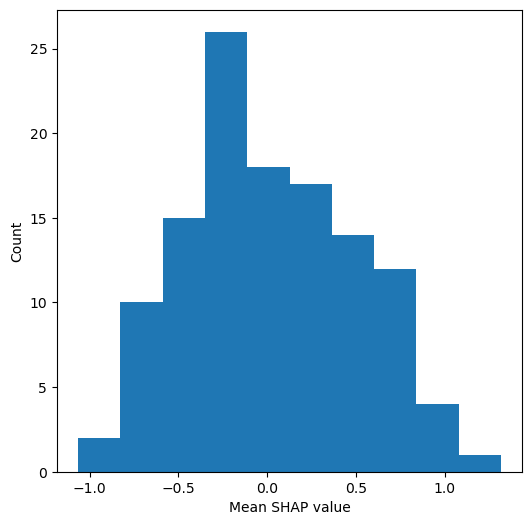

In [34]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(hospital_data['shap_mean'])
ax.set_xlabel('Mean SHAP value')
ax.set_ylabel('Count')

plt.show()

In [35]:
mean_shap = np.mean(hospital_data['shap_mean'])
std_shap = np.std(hospital_data['shap_mean'])
print(f'Mean hospital SHAP: {mean_shap:0.3f}')
print(f'Mean hospital SHAP STDdev: {std_shap:0.3f}')

Mean hospital SHAP: 0.020
Mean hospital SHAP STDdev: 0.478


## Extract benchmark ranking

Sort the above DataFrame with higher mean SHAP values nearer the top. Add a column to show the rank of the team.

In [36]:
hospital_data = hospital_data.sort_values('shap_mean', ascending=False)
hospital_data['Rank'] = np.arange(1, len(hospital_data) + 1)

hospital_data

,stroke_team_id,shap_mean,Rank
101,102,1.317513,1
71,72,1.003472,2
70,71,0.966048,3
7,8,0.958720,4
56,57,0.867143,5
...,...,...,...
64,65,-0.725346,115
116,117,-0.726529,116
57,58,-0.757210,117
25,26,-1.009336,118


Save this dataframe to file:

In [37]:
hospital_data.to_csv(f'{paths.output_folder}/benchmark_codes.csv', index=False)

Pull out the top 25 values. These are the benchmark teams.

In [38]:
benchmark_team_id_list = hospital_data['stroke_team_id'].values[:25]

benchmark_team_id_list

array([102,  72,  71,   8,  57, 115,  37, 104,  48,  83,  21,   2,  64,
        63, 118,  19,  95,  80,  97,  34,  98, 103,  52, 101,  49])